### Import libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV3Small
import glob
print(tf.__version__)

2.9.0


### Importing Data and Preprocessing

The data_path variable contains an absolute file path from the system

In [2]:
data_path = "/Users/aasthatandon/Library/Mobile Documents/com~apple~CloudDocs/CSUEB materials/Spring 2023/BAN 676/Project/data"

This Python code uses glob to find all PNG files in data_path and its subdirectories, and then breast_img[0] is used to access the first file path in the resulting list

In [3]:
breast_img = glob.glob(data_path + '/**/*.png', recursive = True)
breast_img[0]

'/Users/aasthatandon/Library/Mobile Documents/com~apple~CloudDocs/CSUEB materials/Spring 2023/BAN 676/Project/data/IDC_regular_ps50_idx5/9036/0/9036_idx5_x1051_y2401_class0.png'

A loop extracts the label using imgname[-5] as the label is located as the fifth character from the end of the filename and appends it to label_list.

In [4]:
# Extract the label from the filename and create a list of labels
label_list=[]
for imgname in breast_img:
    label = int(imgname[-5])
    label_list.append(label)
label_list[0:5]

[0, 0, 0, 0, 0]

This code creates a Pandas DataFrame from a dictionary with 'Image_name' and 'Class_label' columns, shuffles the rows, resets the index, and displays the first few rows.

In [5]:
data_dict = {'Image_name':breast_img, 'Class_label':label_list}
breast_df = pd.DataFrame(data=data_dict)
breast_df = breast_df.reindex(np.random.permutation(breast_df.index))
breast_df = breast_df.reset_index(drop=True)
breast_df.head()

,Image_name,Class_label
0,/Users/aasthatandon/Library/Mobile Documents/c...,0
1,/Users/aasthatandon/Library/Mobile Documents/c...,0
2,/Users/aasthatandon/Library/Mobile Documents/c...,0
3,/Users/aasthatandon/Library/Mobile Documents/c...,0
4,/Users/aasthatandon/Library/Mobile Documents/c...,0


This code splits the original breast_df DataFrame into train_df and val_df DataFrames with a test size of 0.3. The train_df DataFrame is shuffled and its index is reset before displaying the first few rows.

#### Class Imbalance

Class imbalance happens when one class in a classification problem has significantly fewer examples than others, leading to biased model predictions and reduced performance on the minority class. We are plotting bar plot to visualize class imbalance in our classification Cancer/No cancer problem.

<Axes: >

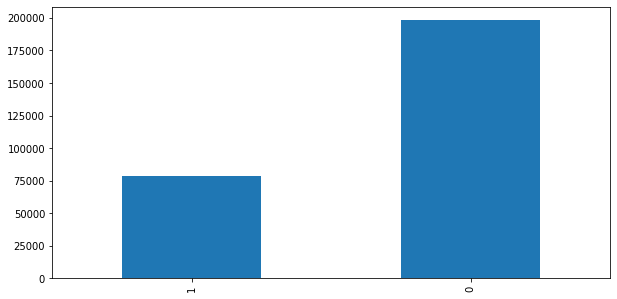

In [48]:
breast_df.Class_label.value_counts().sort_values().plot(kind='bar', figsize=(10, 5)) 

In [6]:
train_df,val_df = sklearn.model_selection.train_test_split(breast_df,test_size=0.3)
train_df = train_df.reindex(np.random.permutation(train_df.index))
train_df = train_df.reset_index(drop=True)
train_df.head()

,Image_name,Class_label
0,/Users/aasthatandon/Library/Mobile Documents/c...,0
1,/Users/aasthatandon/Library/Mobile Documents/c...,1
2,/Users/aasthatandon/Library/Mobile Documents/c...,1
3,/Users/aasthatandon/Library/Mobile Documents/c...,0
4,/Users/aasthatandon/Library/Mobile Documents/c...,0


The val_df DataFrame is shuffled and its index is reset before displaying the first few rows.

In [7]:
val_df = val_df.reindex(np.random.permutation(val_df.index))
val_df = val_df.reset_index(drop=True)
val_df.head()

,Image_name,Class_label
0,/Users/aasthatandon/Library/Mobile Documents/c...,0
1,/Users/aasthatandon/Library/Mobile Documents/c...,0
2,/Users/aasthatandon/Library/Mobile Documents/c...,1
3,/Users/aasthatandon/Library/Mobile Documents/c...,0
4,/Users/aasthatandon/Library/Mobile Documents/c...,1


#### Class Imbalance

Class imbalance happens when one class in a classification problem has significantly fewer examples than others, leading to biased model predictions and reduced performance on the minority class. We are plotting bar plot to visualize class imbalance in our classification Cancer/No cancer problem.

<Axes: >

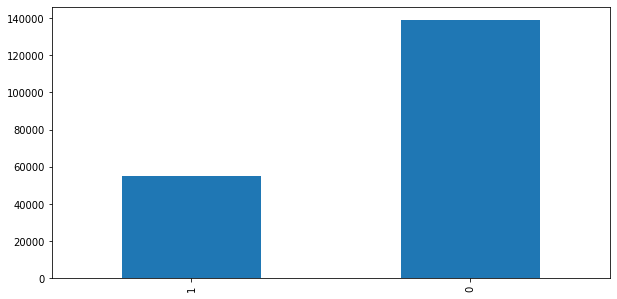

In [8]:
# plotting bar graph : Counting the different class labels in the training data
train_df['Class_label'] = train_df['Class_label'].astype(int)
train_df.Class_label.value_counts().sort_values().plot(kind='bar', figsize=(10, 5)) 

<Axes: >

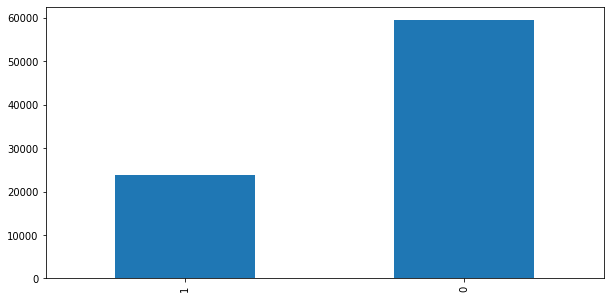

In [9]:
# plotting bar graph : Counting the different class species in the validation data
val_df['Class_label'] = val_df['Class_label'].astype(int)
val_df.Class_label.value_counts().sort_values().plot(kind='bar', figsize=(10, 5)) 

As we can see from above that there is a class imbalance in the data. In order to handle class imbalance, we can following things:

1. Oversampling
2. Penalizing the model more if error occurs in the minority class
3. Data Augmentation

#### Class Weights

In [10]:
# compute class weights to be used later for selective penalization
training_targets = train_df['Class_label']
total = len(training_targets)
class_one = sum(training_targets)
class_zero = total - class_one
class_weights = {0: 1-class_zero/total, 1: 1-class_one/total}
print("class wieghts: {}".format(class_weights))

class wieghts: {0: 0.2835853932237242, 1: 0.7164146067762758}


In [11]:
train_df.head()

,Image_name,Class_label
0,/Users/aasthatandon/Library/Mobile Documents/c...,0
1,/Users/aasthatandon/Library/Mobile Documents/c...,1
2,/Users/aasthatandon/Library/Mobile Documents/c...,1
3,/Users/aasthatandon/Library/Mobile Documents/c...,0
4,/Users/aasthatandon/Library/Mobile Documents/c...,0


#### Data Visualization :We will do some data visualization

In [12]:
cancer_var = {0 : 'Non Cancer', 1 : "Cancer"}

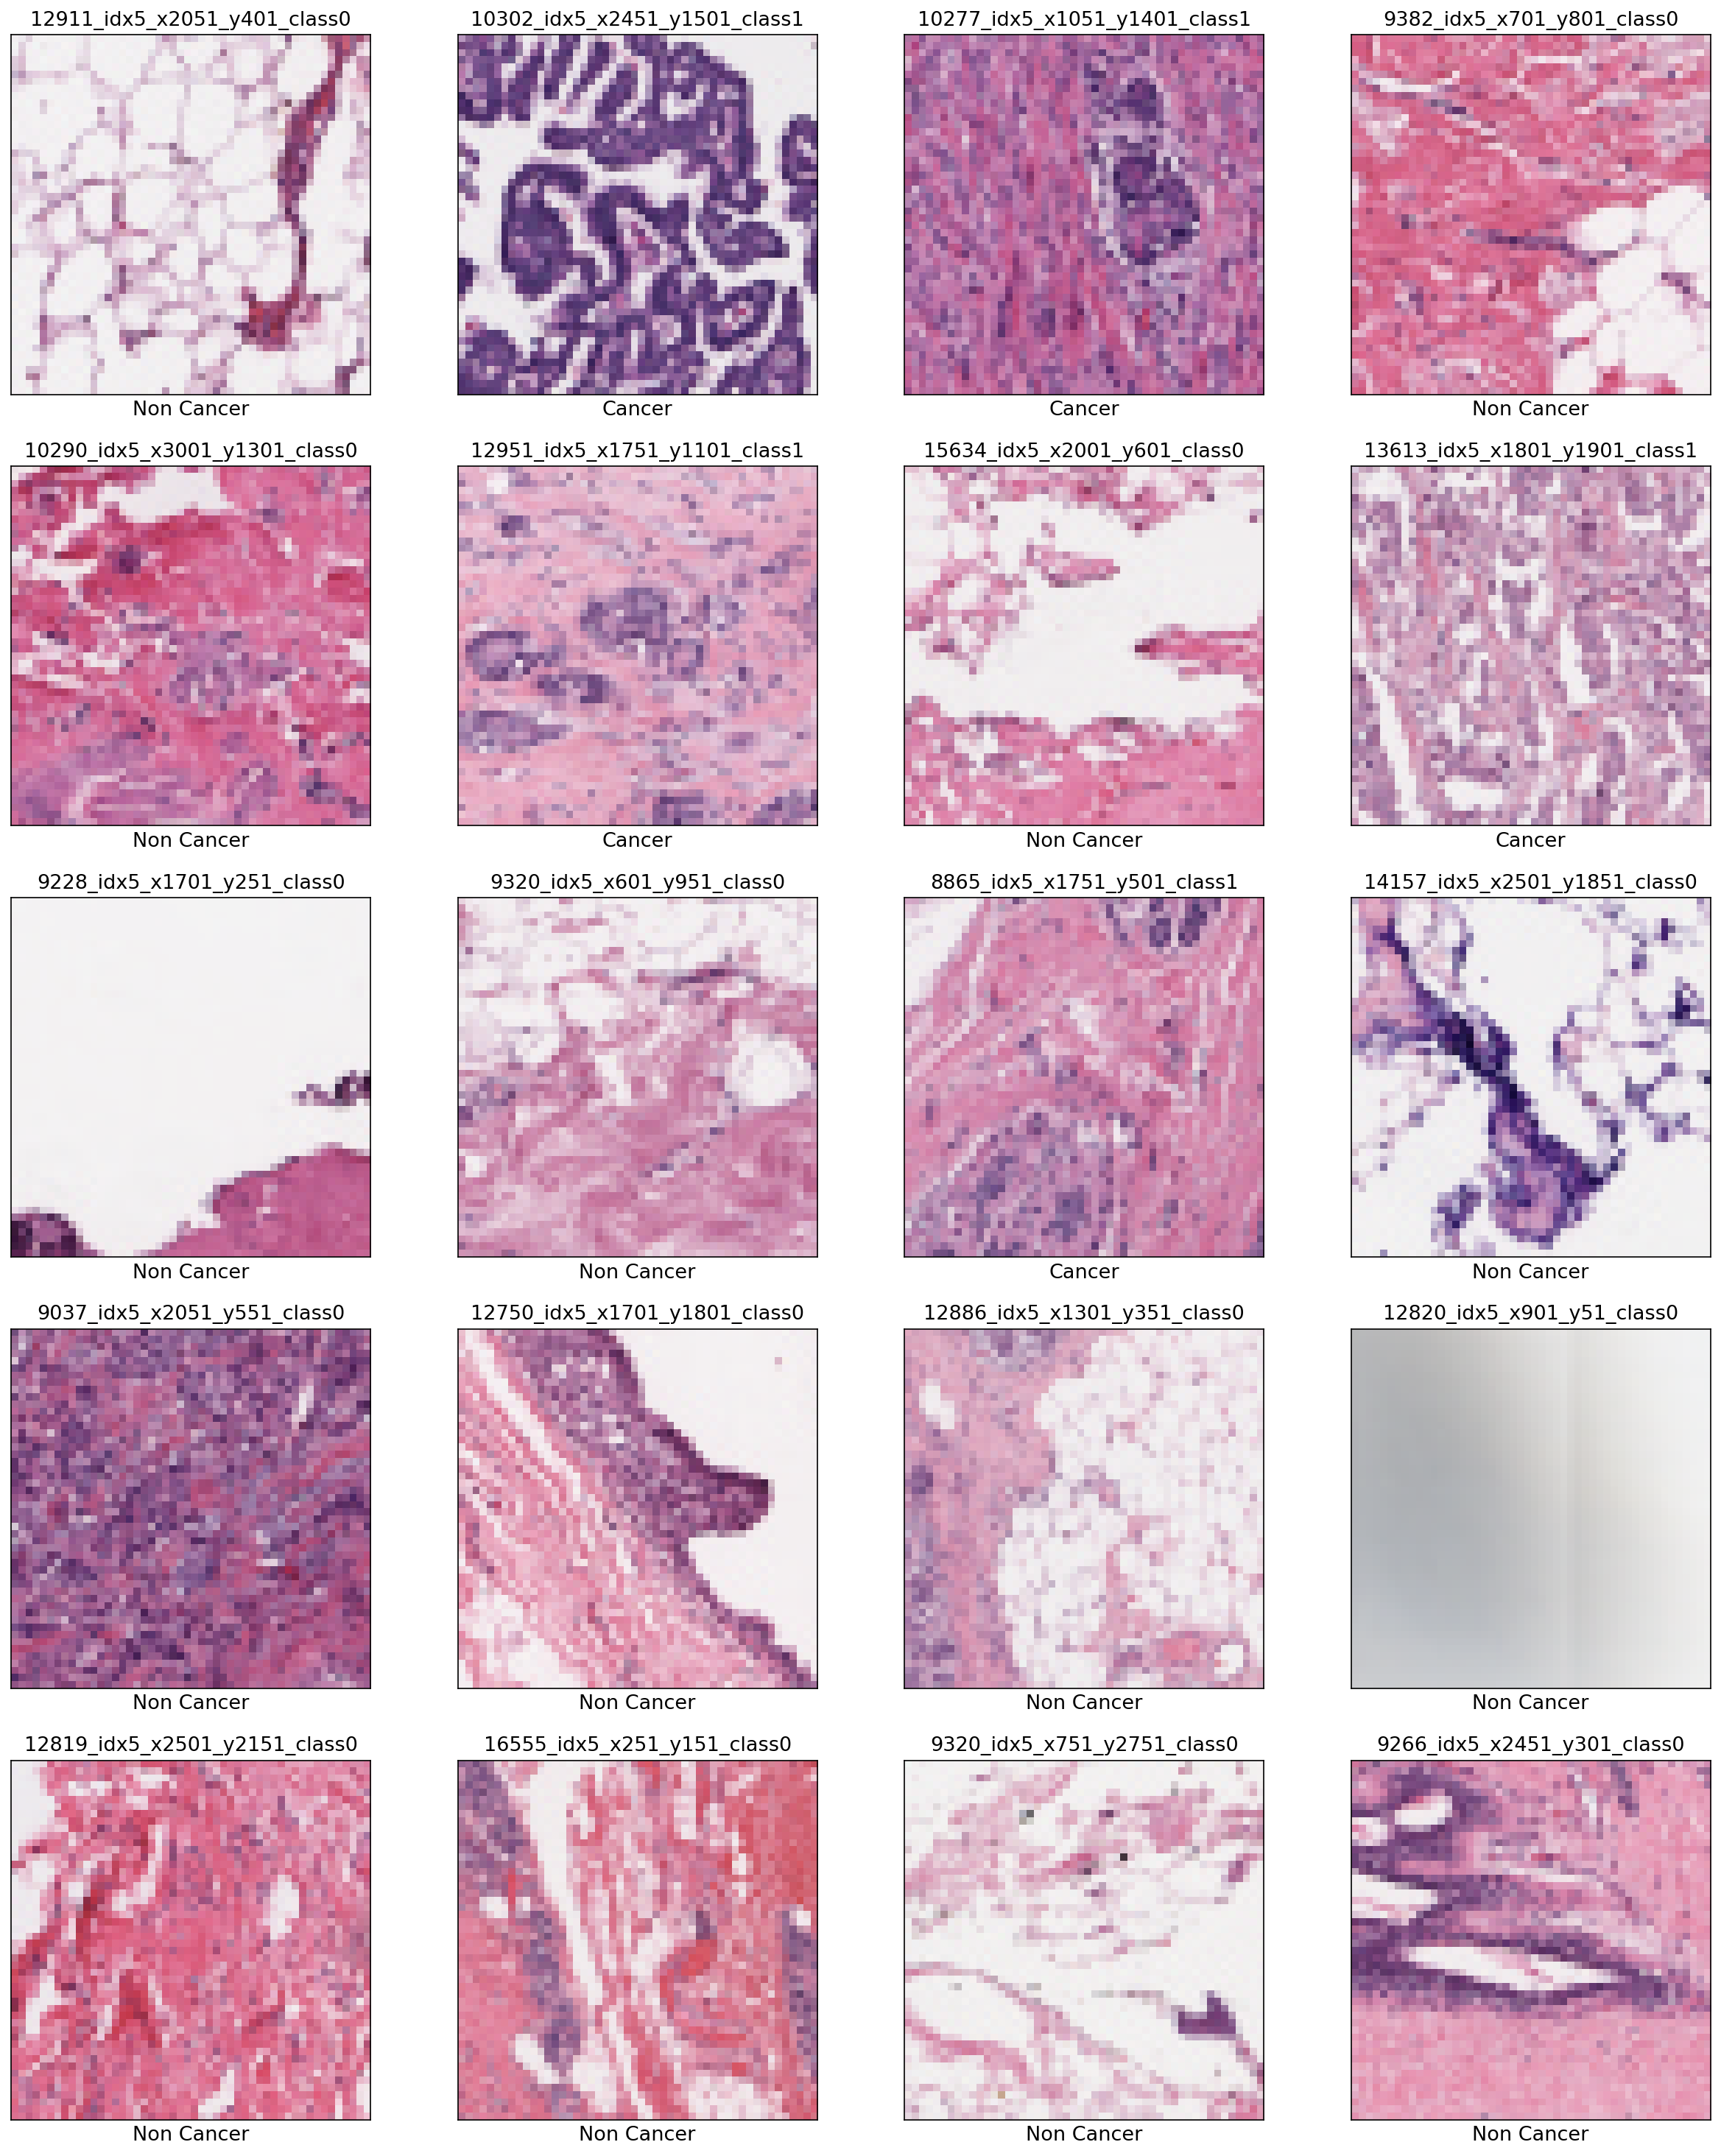

In [13]:
plt.figure(figsize=(20,25),dpi =150)

for i in range(20):
    plt.subplot(5,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_path = train_df['Image_name'][i]
    image_name = image_path.split('/')[-1].split('.')[0]
    image = plt.imread(image_path)
    plt.imshow(image)
    cls_lb = int(train_df['Class_label'][i])
    cls_name = cancer_var[cls_lb]
    plt.xlabel(cls_name,fontsize=13)
    plt.title(image_name,fontsize =13)

All images have 50 x 50 size, so we will use 50 x 50

### Data Augmentation

The 'prepare_data_pipeline' function generates data generators for training and validation sets. It uses the 'ImageDataGenerator' class to apply data augmentation and preprocessing pipelines to the input images. The resulting 'train_generator' and 'valid_generator' objects can be used to train and evaluate machine learning models for the cancer classification.

In [14]:
def prepare_data_pipeline(
    rescale=None, preprocessing_fn=None, target_size=(32,32), batch_size=32
):
    train_image_gen = ImageDataGenerator(
        rescale=rescale,
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        preprocessing_function=preprocessing_fn
    )
    
    valid_image_gen = ImageDataGenerator(
        rescale=rescale, preprocessing_function=preprocessing_fn
    )
    
    train_df['Class_label'] = train_df['Class_label'].astype(str)
    val_df['Class_label'] = val_df['Class_label'].astype(str)

    train_generator = train_image_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col="Image_name",
    y_col="Class_label",
    subset=None,
    batch_size=batch_size,
    seed=123,
    shuffle=True,
    class_mode="binary",
    target_size=target_size)


    valid_generator = valid_image_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col="Image_name",
    y_col="Class_label",
    subset=None,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False,
    target_size=target_size)
    
    return train_generator, valid_generator

### Baseline Naive Model

It randomly assign class label to the given example based on probability of happening
of each class from training data. We look at probability distribution of each class in training data.


In [15]:
from sklearn.metrics import classification_report

# making Naive model
def naive_model_errors(train_df, val_df): 
    random.seed(1234)
    print("Accuracy using Naive Model")
    total_train = train_df['Class_label'].shape[0]
    total_val = val_df['Class_label'].shape[0]
    train_prob = train_df.Class_label.value_counts()/total_train
    train_prob = dict(train_prob)
    cls_lbs = []
    cls_prob = []
    for lb, prob in train_prob.items():
        cls_lbs.append(int(lb))
        cls_prob.append(prob)


    train_prd = random.choices(cls_lbs, weights= cls_prob, k=total_train)
    val_prd = random.choices(cls_lbs, weights=cls_prob, k=total_val)

    # accuracy_train = accuracy_score(train_df['Class_label'].astype(int), train_prd)
    # print("Training Accuracy: " + str(accuracy_train))
    
    validation_targets = val_df['Class_label'].astype(int)
    accuracy_val = accuracy_score(validation_targets, val_prd)
    print("Validation Accuracy: " + str(accuracy_val))
    clf_report = classification_report(
        validation_targets, val_prd, target_names=['class 0', 'class 1']
    )
    print(clf_report)
    print("=====================================================")


In [16]:
naive_model_errors(train_df, val_df)

Accuracy using Naive Model
Validation Accuracy: 0.5968555574239112
              precision    recall  f1-score   support

     class 0       0.72      0.72      0.72     59563
     class 1       0.29      0.29      0.29     23695

    accuracy                           0.60     83258
   macro avg       0.50      0.50      0.50     83258
weighted avg       0.60      0.60      0.60     83258



- The Naive Model's validation accuracy is 0.60, correctly classifying 60% of instances. 
- Recall for class 0 are 0.72, while for class 1 they are 0.28, indicating a low performance. 
- Precison for class 0 are 0.71, while for class 1 they are 0.29, indicating a low performance. 
- The F1-score for class 0 is 0.72, showing a good balance between precision and recall, while for class 1 it is 0.28, indicating a low performance. 
- The model's weighted average of precision, recall, and F1-score is 0.59, indicating relatively poor performance. 
- The macro-average is 0.50, indicating a poor balance between the two classes.


Our aim here is to
make a model that performs better than this Naive Model.




### a. Building Model 1 from scratch using CNN layers

This code prepares a data pipeline for training the model with 50 epochs. To help the model converge better during training, a learning rate scheduler is employed to reduce the learning rate of the optimizer. The decay_steps variable is calculated by multiplying the number of batches in the training data generator and the number of epochs, and is used to set the decay_steps parameter for the scheduler.

In [17]:
train_generator, valid_generator = prepare_data_pipeline(rescale=1./255,  batch_size=128, target_size=(50, 50))
num_epochs = 50
decay_steps = len(train_generator) * num_epochs

Found 194266 validated image filenames belonging to 2 classes.
Found 83258 validated image filenames belonging to 2 classes.


The model architecture includes several convolutional and pooling layers, as well as batch normalization and dropout layers to prevent overfitting. The final layer is a sigmoid activation function, indicating binary classification. The model uses the Adam optimizer with a learning rate schedule defined by the CosineDecay function, and metrics including binary accuracy, precision, and recall are also defined. The input_shape and decay_steps parameters can be optionally specified when calling the function.

In [18]:
def make_cnn_model(input_shape=(50,50,3), decay_steps=100):
    # start building model
    model = Sequential(name="model_cnn")
    # Feature extraction
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding='same'))
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3,3)))
    
    model.add(GlobalAveragePooling2D())
    
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))
 
    # Mapping Process (Map the features to the classes)
    #model.add(Flatten())
    model.add(Dense(16))
    model.add(Activation('relu'))
    #model.add(Dropout(0.2))
    # Output classes are 2
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    #model.add(Activation('softmax'))

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learnin, decay_steps=decay_steps, alpha=0.0, name=None)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    metrics = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    
    return model

In [19]:
model = make_cnn_model(input_shape=(50,50,3), decay_steps=decay_steps)


In [20]:
model.summary()

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 50, 50, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0 

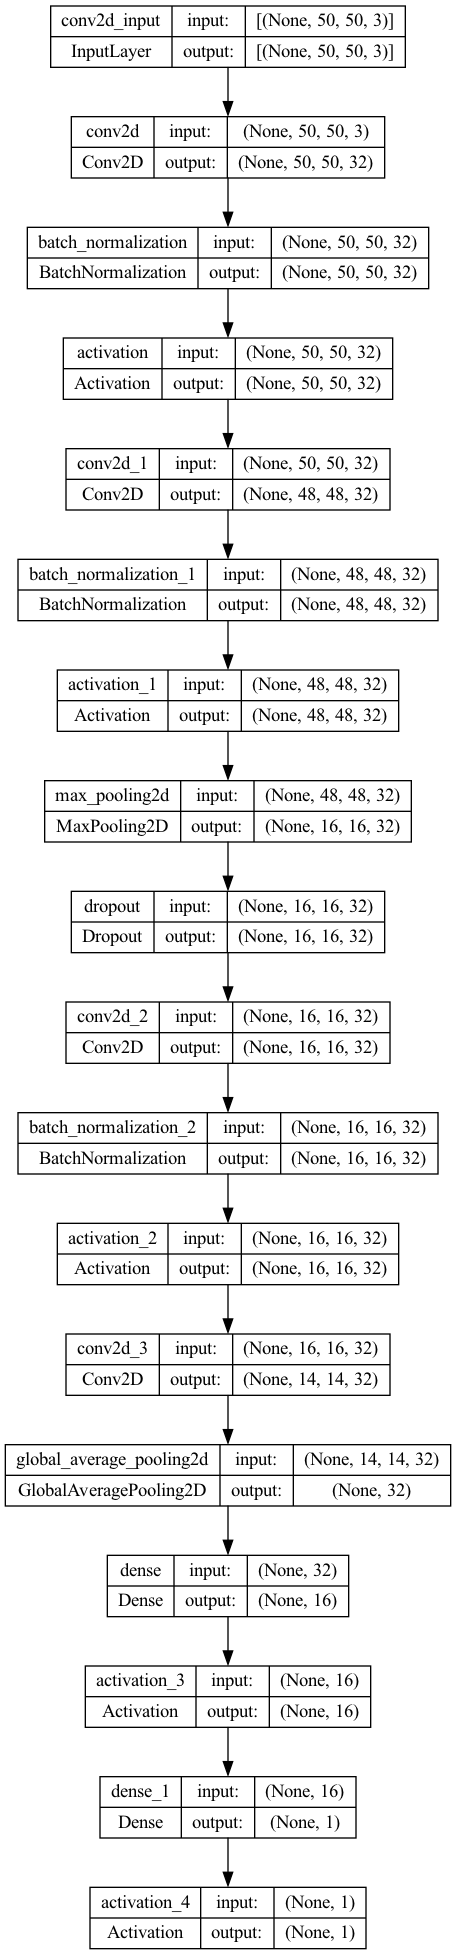

In [21]:
keras.utils.plot_model(model, "cnn_model.png", show_shapes=True)

This code defines fit_model function that trains the model using fit method. It takes the model object, training and validation data generators, along with optional parameters like class weights and number of epochs. The function returns the trained model object and training history.

In [22]:
def fit_model(model, train_gen, valid_gen, num_epochs=50, class_weights={0: 0.5, 1: 0.5}): 
    
    print("\nTraining model")
    print("Will use class weights: {}".format(class_weights))
    model.reset_states()
    m_history = model.fit(
      x=train_gen, validation_data=valid_gen, epochs=num_epochs, verbose=1, workers=4, 
      class_weight=class_weights
    )

    print("\n")
    print("=====================")

    return model, m_history

In [23]:
model, m_history = fit_model(
    model, train_gen=train_generator, valid_gen=valid_generator, num_epochs=num_epochs,
    class_weights=class_weights
)


Training model
Will use class weights: {0: 0.2835853932237242, 1: 0.7164146067762758}
Epoch 1/50
1518/1518 [==============================] - 109s 70ms/step - loss: 0.1551 - binary_accuracy: 0.8323 - precision: 0.6607 - recall: 0.8402 - val_loss: 0.4675 - val_binary_accuracy: 0.7842 - val_precision: 0.5801 - val_recall: 0.8752
Epoch 2/50
1518/1518 [==============================] - 128s 84ms/step - loss: 0.1421 - binary_accuracy: 0.8499 - precision: 0.6896 - recall: 0.8557 - val_loss: 0.4968 - val_binary_accuracy: 0.8215 - val_precision: 0.8271 - val_recall: 0.4714
Epoch 3/50
1518/1518 [==============================] - 143s 94ms/step - loss: 0.1379 - binary_accuracy: 0.8551 - precision: 0.6983 - recall: 0.8614 - val_loss: 0.4221 - val_binary_accuracy: 0.8174 - val_precision: 0.6422 - val_recall: 0.8097
Epoch 4/50
1518/1518 [==============================] - 142s 94ms/step - loss: 0.1344 - binary_accuracy: 0.8587 - precision: 0.7050 - recall: 0.8627 - val_loss: 0.3437 - val_binary_acc

The function plot_history_models plots the training and validation loss and accuracy for multiple models using a line plot. It takes model histories, the metric to plot, and the y-axis limits as input, and creates a labeled plot.

In [24]:
def plot_history_models(histories, key='loss', ylim=[0, 1]):
    plt.figure(figsize=(7,5), dpi=150)
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])
    plt.ylim(ylim)
    plt.grid()

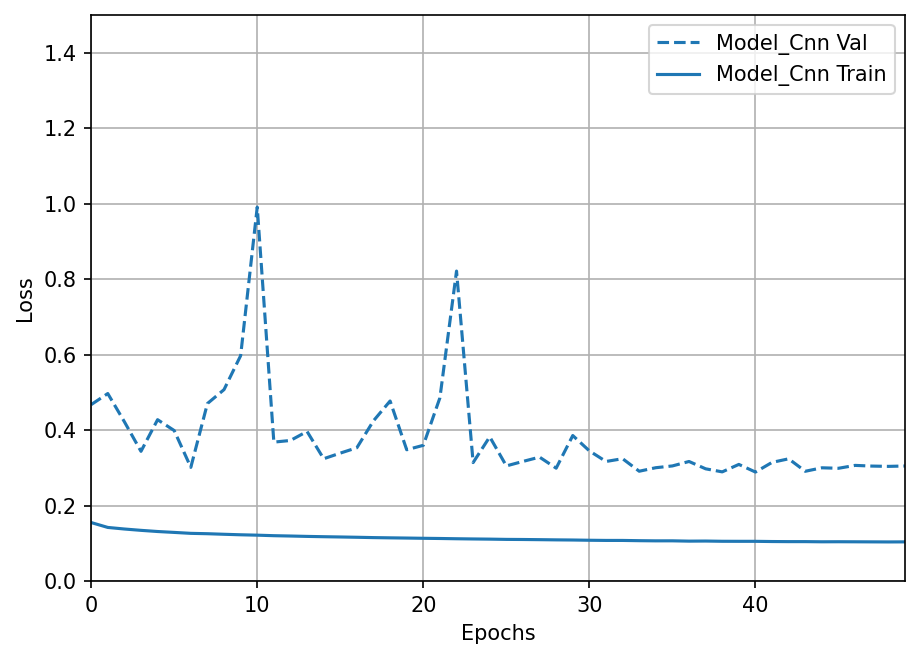

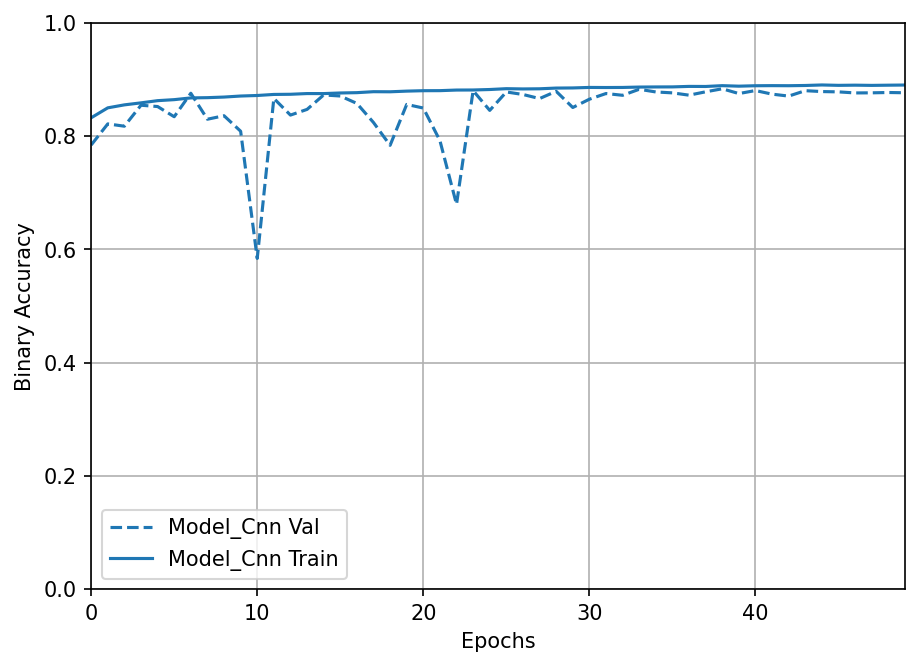

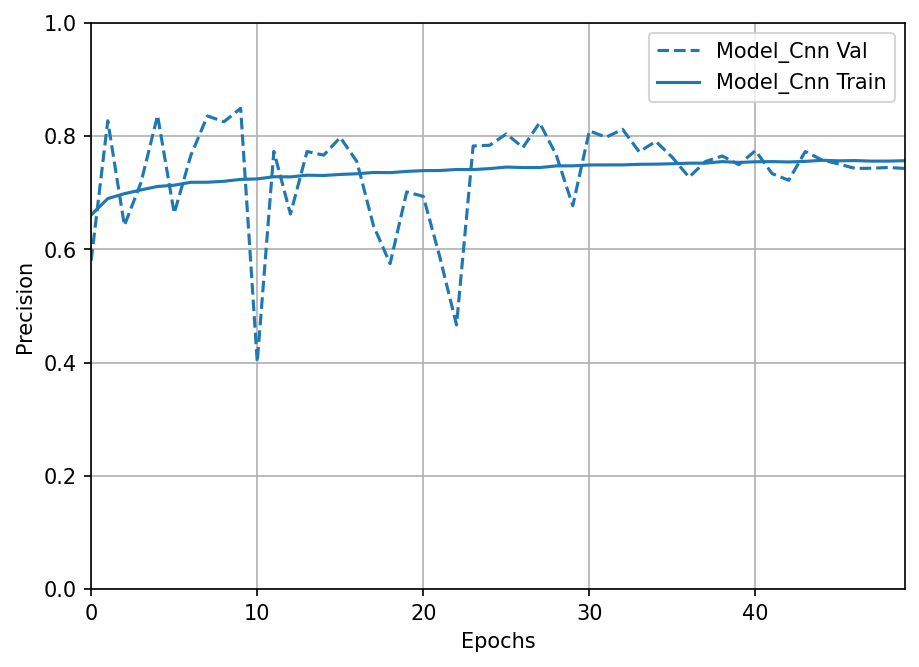

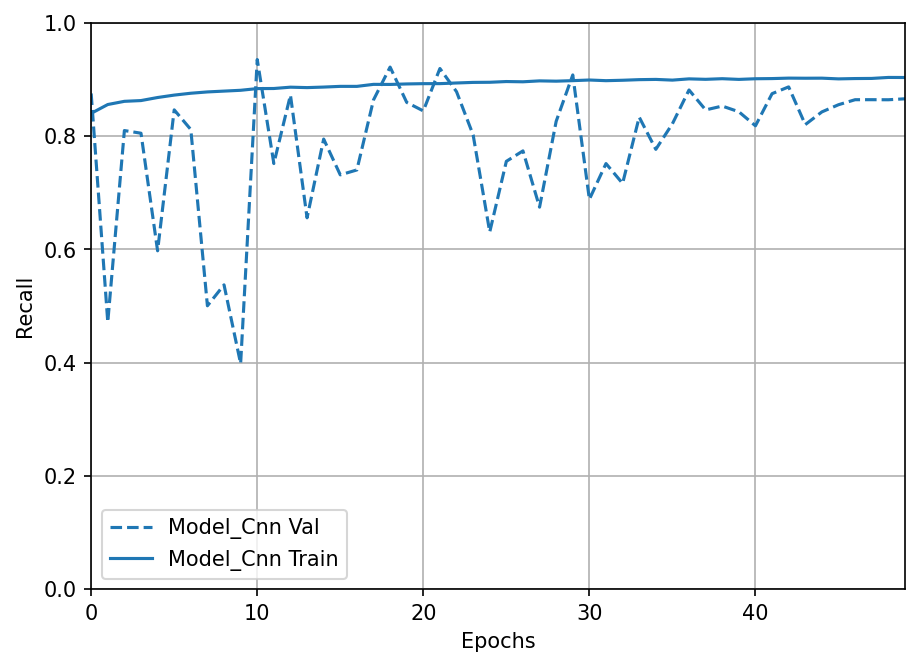

In [25]:
plot_history_models([('Model_CNN', m_history)], key='loss', ylim=[0,1.5])
plot_history_models([('Model_CNN', m_history)], key='binary_accuracy', ylim=[0, 1.0])
plot_history_models([('Model_CNN', m_history)], key='precision', ylim=[0, 1.0])
plot_history_models([('Model_CNN', m_history)], key='recall', ylim=[0, 1.0])

This code evaluates a binary classification model using a validation dataset. It generates predictions, converts them to binary, and prints a classification report containing precision, recall, and F1-score metrics for each class

In [26]:
predictions_cnn = model.predict(valid_generator)
validation_targets = val_df['Class_label'].astype(int)

val_prd_cnn = [1 if v > 0.5 else 0 for v in predictions_cnn] # converting to binary
clf_report_cnn = classification_report(validation_targets, val_prd_cnn, target_names=['class 0', 'class 1'])
print(clf_report_cnn)
print("================================================")

651/651 [==============================] - 31s 47ms/step
              precision    recall  f1-score   support

     class 0       0.94      0.88      0.91     59563
     class 1       0.74      0.87      0.80     23695

    accuracy                           0.88     83258
   macro avg       0.84      0.87      0.86     83258
weighted avg       0.89      0.88      0.88     83258



- Accuracy for the model is 88%.

- Precision is the number of true positive predictions divided by the total number of positive predictions. For class 0, precision is 0.93, meaning that 93% of the predicted class 0 instances are actually class 0. For class 1, precision is 0.77, meaning that 77% of the predicted class 1 instances are actually class 1.

- Recall is the number of true positive predictions divided by the total number of positive instances in the dataset. For class 0, recall is 0.90, meaning that 90% of the actual class 0 instances were correctly identified by the model. For class 1, recall is 0.84, meaning that 84% of the actual class 1 instances were correctly identified by the model.

- F1-score is the harmonic mean of precision and recall, where F1-score = 2 * (precision * recall) / (precision + recall). It gives a balance between precision and recall. For class 0, the F1-score is 0.91, while for class 1 it is 0.80.

Regularized CNN model

In [27]:
l2_reg = tf.keras.regularizers.L2(l2=0.001)

def make_cnn_model_reg(input_shape=(50,50,3), decay_steps=1000):
    # start building model
    model = Sequential(name="model_cnn_regularize")
    # Feature extraction
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape,kernel_regularizer=l2_reg))
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3),kernel_regularizer=l2_reg))
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding='same',kernel_regularizer=l2_reg))
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3,3),kernel_regularizer=l2_reg))
    
    model.add(GlobalAveragePooling2D())
    
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))
 
    # Mapping Process (Map the features to the classes)
    #model.add(Flatten())
    model.add(Dense(16,kernel_regularizer=l2_reg))
    model.add(Activation('relu'))
    #model.add(Dropout(0.2))
    # Output classes are 2
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    #model.add(Activation('softmax'))

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3, decay_steps=decay_steps, alpha=0.0, name=None)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    metrics = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    
    return model

In [28]:
model_reg = make_cnn_model_reg(input_shape=(50,50,3), decay_steps=decay_steps)

In [29]:
model_reg.summary()

Model: "model_cnn_regularize"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        896       
                                                                 
 batch_normalization_3 (Batc  (None, 50, 50, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 50, 50, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 48, 48, 32

In [30]:
model_reg, m_history_reg = fit_model(
    model_reg, train_gen=train_generator, valid_gen=valid_generator, num_epochs=num_epochs,
    class_weights=class_weights
)


Training model
Will use class weights: {0: 0.2835853932237242, 1: 0.7164146067762758}
Epoch 1/50
1518/1518 [==============================] - 203s 133ms/step - loss: 0.1884 - binary_accuracy: 0.8317 - precision: 0.6600 - recall: 0.8385 - val_loss: 0.3965 - val_binary_accuracy: 0.8327 - val_precision: 0.6930 - val_recall: 0.7400
Epoch 2/50
1518/1518 [==============================] - 213s 140ms/step - loss: 0.1607 - binary_accuracy: 0.8409 - precision: 0.6740 - recall: 0.8501 - val_loss: 1.0726 - val_binary_accuracy: 0.7662 - val_precision: 0.8364 - val_recall: 0.2218
Epoch 3/50
1518/1518 [==============================] - 223s 147ms/step - loss: 0.1564 - binary_accuracy: 0.8456 - precision: 0.6825 - recall: 0.8517 - val_loss: 0.4351 - val_binary_accuracy: 0.8102 - val_precision: 0.6401 - val_recall: 0.7608
Epoch 4/50
1518/1518 [==============================] - 212s 140ms/step - loss: 0.1538 - binary_accuracy: 0.8475 - precision: 0.6862 - recall: 0.8519 - val_loss: 0.8456 - val_binary

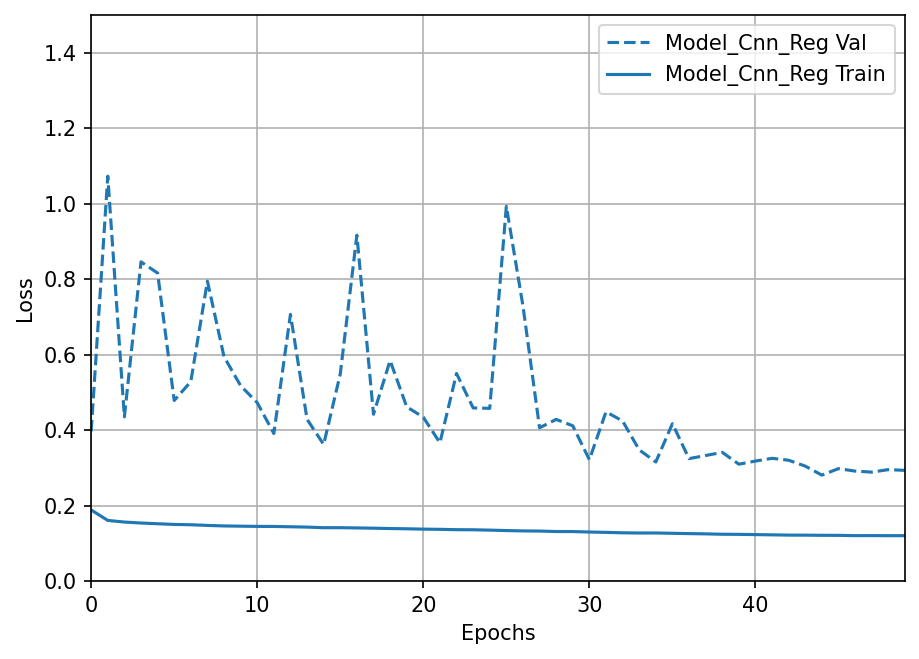

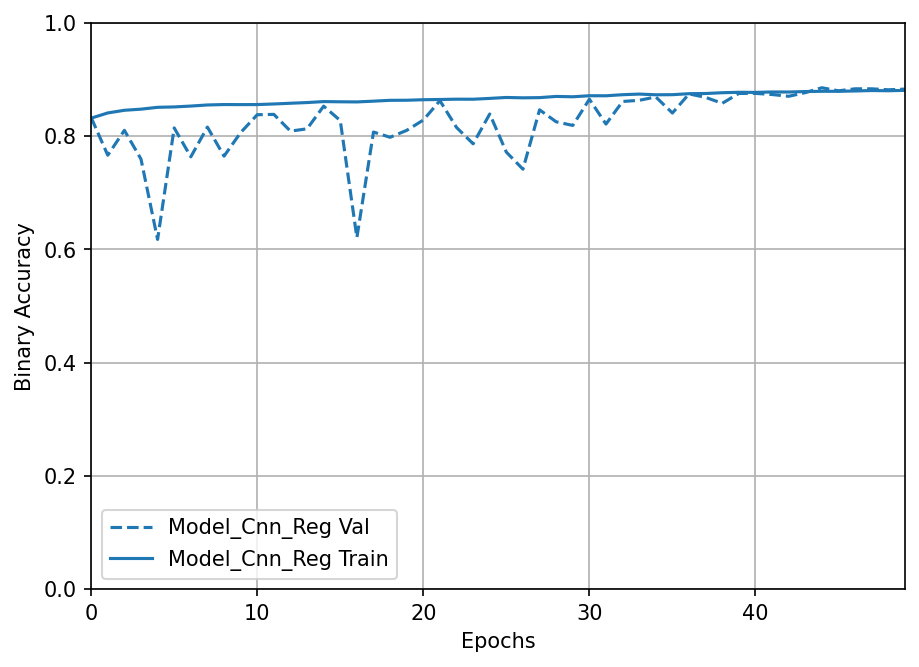

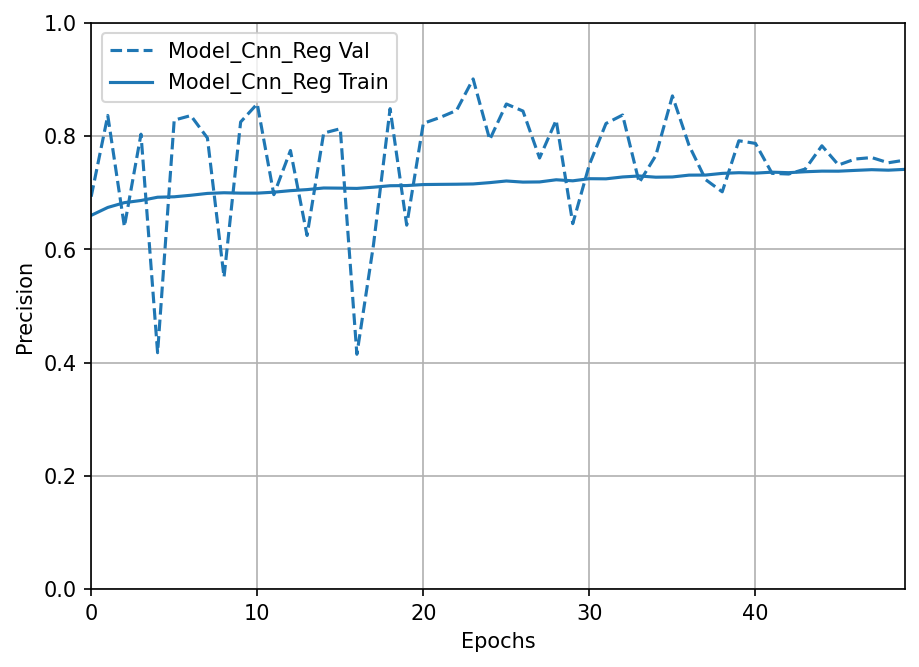

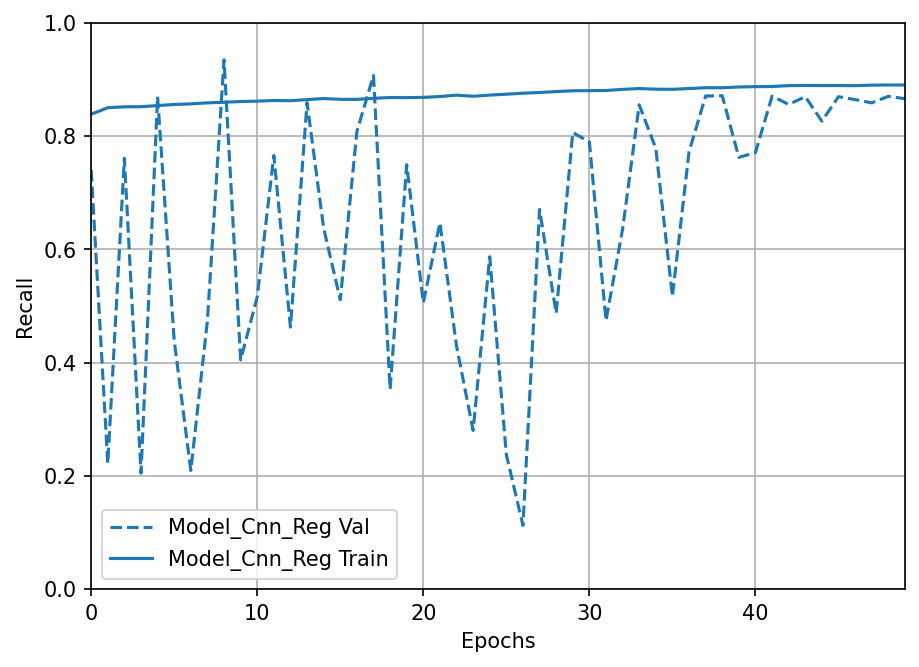

In [31]:
plot_history_models([('Model_CNN_reg', m_history_reg)], key='loss', ylim=[0,1.5])
plot_history_models([('Model_CNN_reg', m_history_reg)], key='binary_accuracy', ylim=[0, 1.0])
plot_history_models([('Model_CNN_reg', m_history_reg)], key='precision', ylim=[0, 1.0])
plot_history_models([('Model_CNN_reg', m_history_reg)], key='recall', ylim=[0, 1.0])

In [32]:
predictions_reg = model_reg.predict(valid_generator)
validation_targets = val_df['Class_label'].astype(int)

val_prd_reg = [1 if v > 0.5 else 0 for v in predictions_reg] # converting to binary
clf_report_reg = classification_report(validation_targets, val_prd_reg, target_names=['class 0', 'class 1'])
print(clf_report_reg)
print("================================================")

651/651 [==============================] - 31s 47ms/step
              precision    recall  f1-score   support

     class 0       0.94      0.89      0.92     59563
     class 1       0.76      0.87      0.81     23695

    accuracy                           0.88     83258
   macro avg       0.85      0.88      0.86     83258
weighted avg       0.89      0.88      0.89     83258



The model achieved an overall accuracy of 0.88, which means that 88% of the predictions were correct.

For class 0, the precision was 0.94, which means that 94% of the predictions for class 0 were correct. The recall was 0.89, which means that 89% of the actual class 0 instances were correctly identified. The F1-score was 0.92, which is the harmonic mean of precision and recall.

For class 1, the precision was 0.76, which means that 76% of the predictions for class 1 were correct. The recall was 0.86, which means that 86% of the actual class 1 instances were correctly identified. The F1-score was 0.81.

Overall, the model seems to perform reasonably well, with high precision and recall for class 0, and slightly lower but still respectable values for class 1.

### Residual Net CNN Model

The code defines a function to create a residual block and another function to create a convolutional neural network (CNN) model for binary classification tasks. The model includes residual blocks, global average pooling, dense layers, and a sigmoid output layer, and is compiled with the Adam optimizer using binary cross-entropy loss and evaluated using binary accuracy, precision, and recall. The residual blocks help preserve information through the network.

In [33]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add
from keras.layers.convolutional import MaxPooling2D

def residual_block(x, filters, kernel_size=3, strides=1, activation='relu'):
    # Save the input tensor
    x_shortcut = x
    
    # First convolutional layer
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    # Second convolutional layer
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Add the input tensor to the output of the residual block
    x = Add()([x, x_shortcut])
    x = Activation(activation)(x)
    
    return x

def make_cnn_model_residual(input_shape=(112,112,3), decay_steps=1000):
    # start building model
    inputs = keras.Input(shape=input_shape, name="img")
    x = Conv2D(32, 7, activation="relu", strides=2)(inputs)
    x = MaxPooling2D(2)(x)
    
    x = residual_block(x, 32, kernel_size=3, strides=1, activation='relu')
    x = MaxPooling2D(2)(x)
    
    x = residual_block(x, 32, kernel_size=3, strides=1, activation='relu')
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(16)(x)
    x = Activation('relu')(x)
    x = Dense(1)(x)
    prob = Activation('sigmoid')(x)
    model = keras.Model(inputs, outputs=prob, name="mode_cnn_residual")
    
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3, decay_steps=decay_steps, alpha=0.0, name=None)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    metrics = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    
    model.summary()
    return model
    
    

In [34]:

model_residual = make_cnn_model_residual(input_shape=(50,50,3), decay_steps=decay_steps)

Model: "mode_cnn_residual"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 22, 22, 32)   4736        ['img[0][0]']                    
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 11, 11, 32)  0           ['conv2d_8[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 11, 11, 32)   9248        ['max_pooling2d_2[0][0]']        
                                                                                  

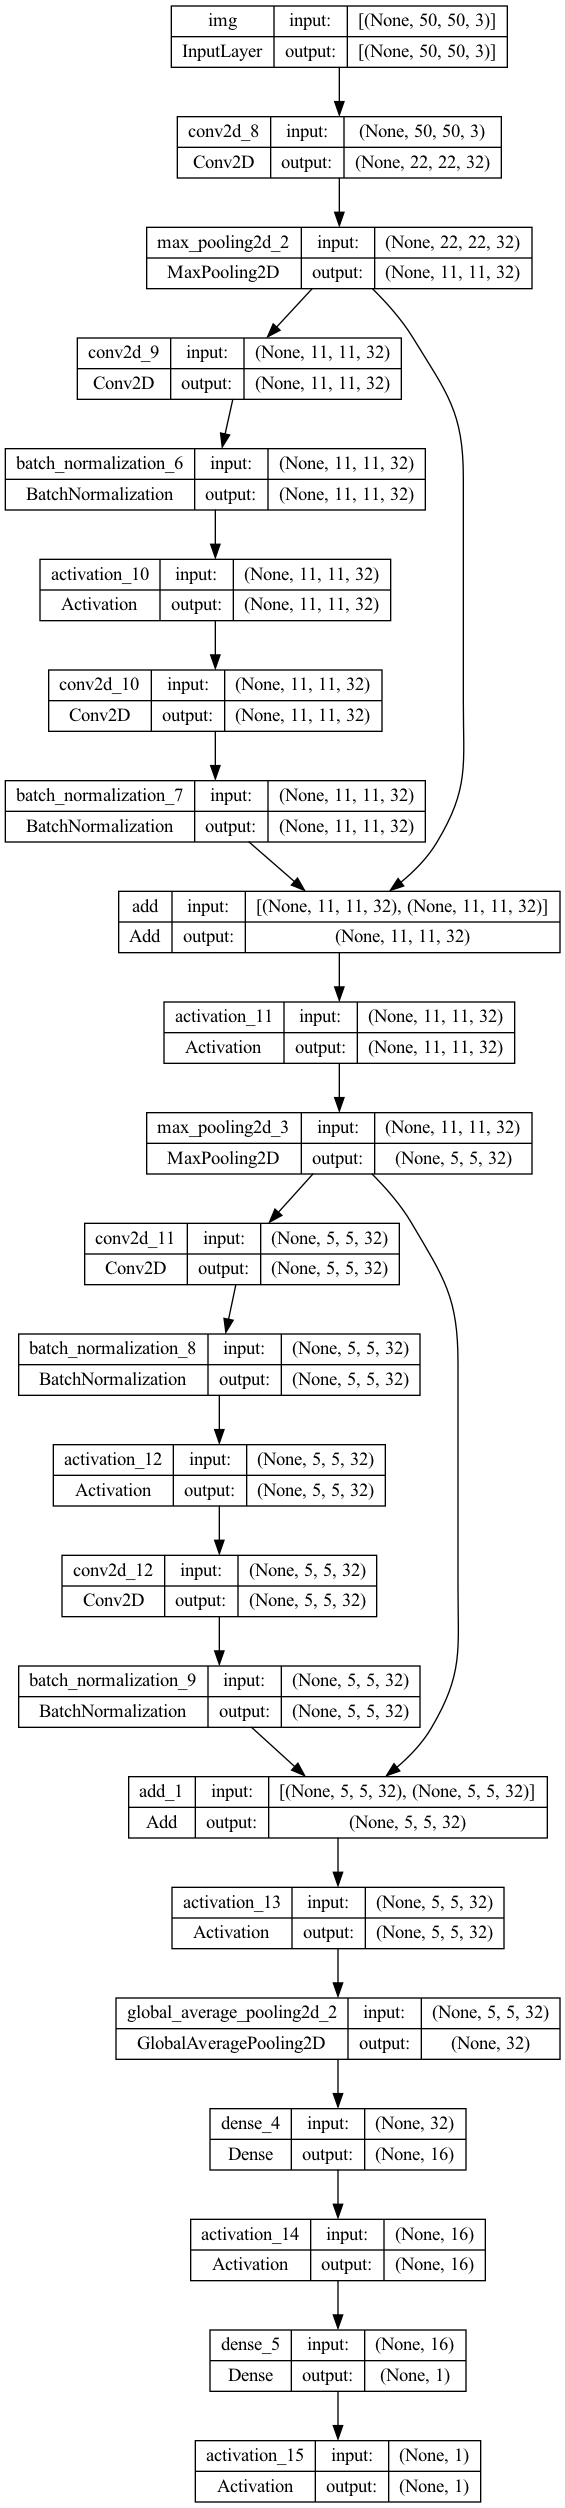

In [35]:
keras.utils.plot_model(model_residual, "residual_model.png", show_shapes=True)

In [36]:
model_residual, m_residual_history = fit_model(
    model_residual, train_gen=train_generator, valid_gen=valid_generator, num_epochs=num_epochs,
    class_weights=class_weights
)


Training model
Will use class weights: {0: 0.2835853932237242, 1: 0.7164146067762758}
Epoch 1/50
1518/1518 [==============================] - 106s 68ms/step - loss: 0.1630 - binary_accuracy: 0.8257 - precision: 0.6536 - recall: 0.8195 - val_loss: 0.4198 - val_binary_accuracy: 0.8289 - val_precision: 0.8008 - val_recall: 0.5306
Epoch 2/50
1518/1518 [==============================] - 102s 67ms/step - loss: 0.1524 - binary_accuracy: 0.8382 - precision: 0.6721 - recall: 0.8387 - val_loss: 0.4236 - val_binary_accuracy: 0.8131 - val_precision: 0.6575 - val_recall: 0.7162
Epoch 3/50
1518/1518 [==============================] - 102s 67ms/step - loss: 0.1465 - binary_accuracy: 0.8455 - precision: 0.6828 - recall: 0.8500 - val_loss: 0.5269 - val_binary_accuracy: 0.8221 - val_precision: 0.7977 - val_recall: 0.5023
Epoch 4/50
1518/1518 [==============================] - 103s 67ms/step - loss: 0.1425 - binary_accuracy: 0.8483 - precision: 0.6864 - recall: 0.8561 - val_loss: 0.5125 - val_binary_acc

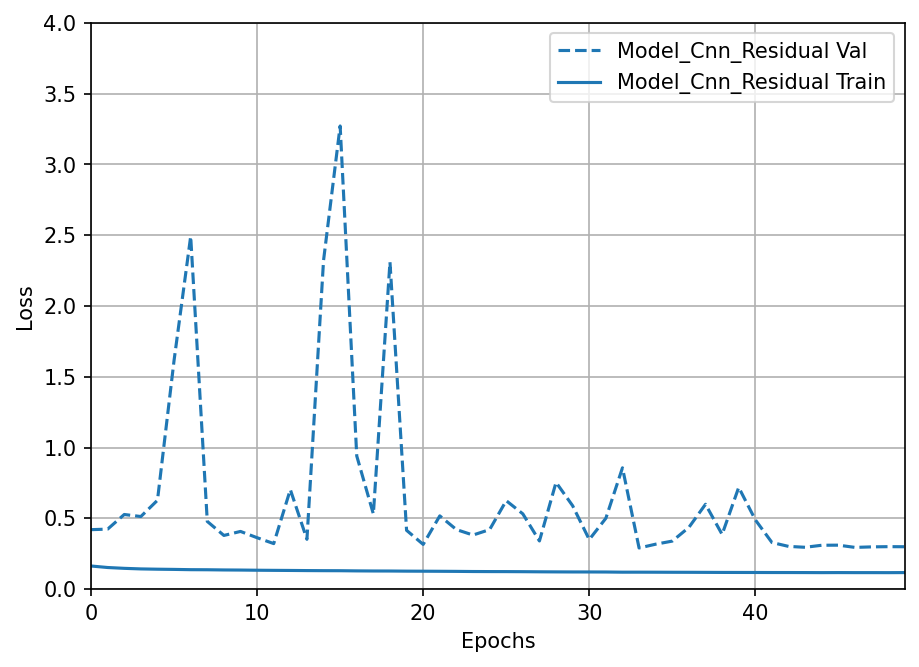

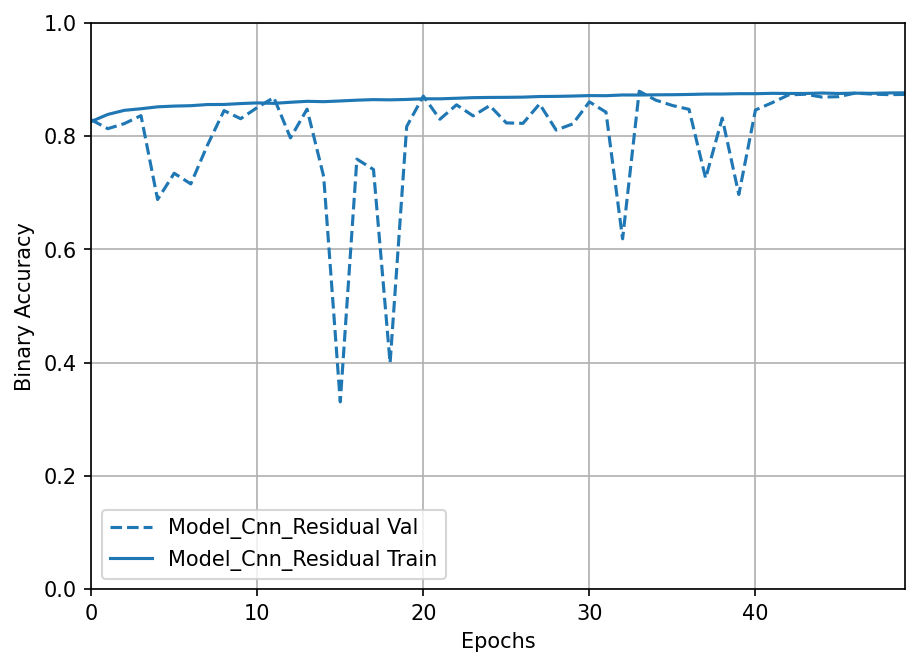

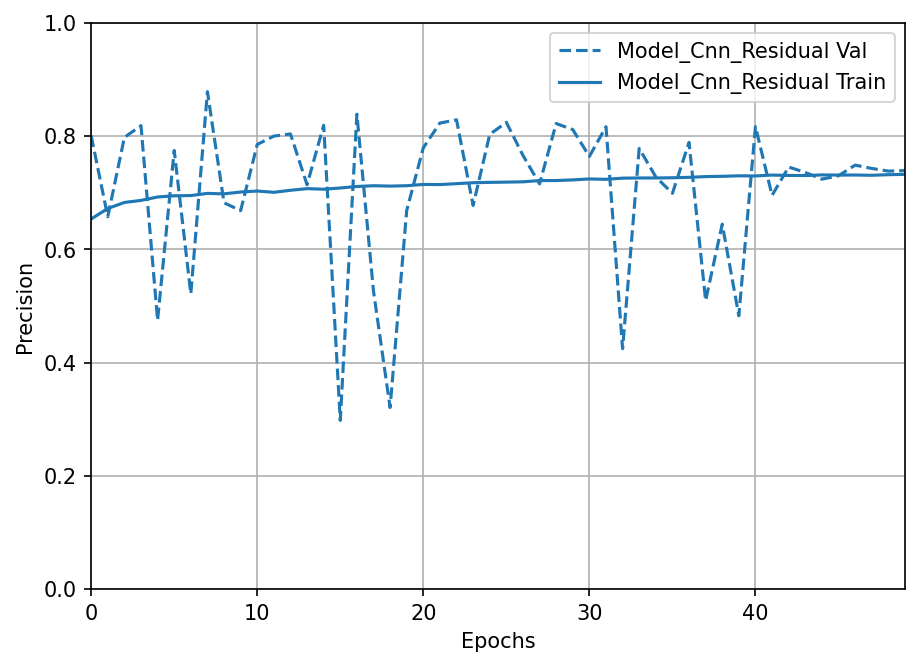

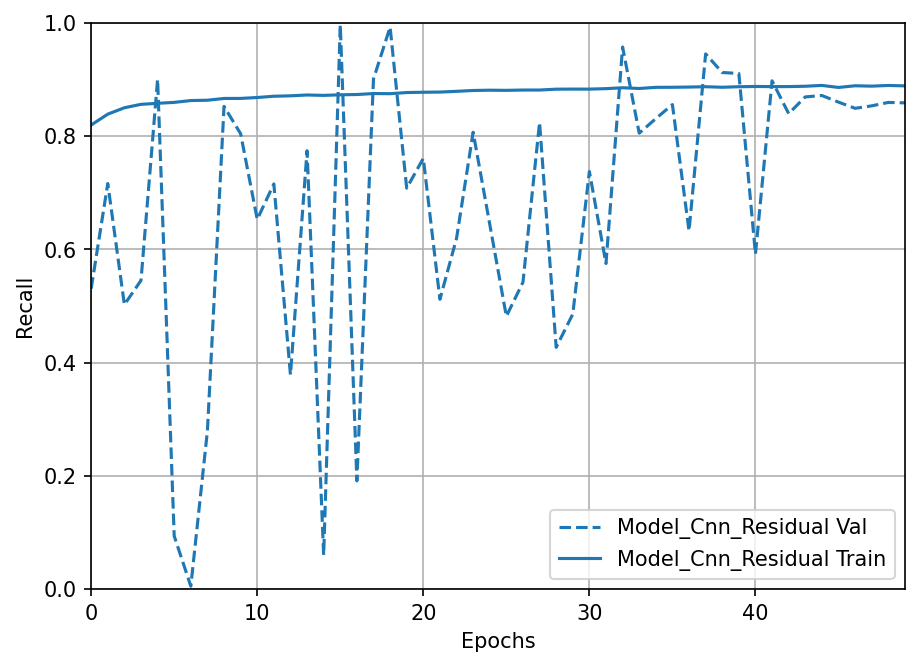

In [50]:
plot_history_models([('Model_CNN_Residual', m_residual_history)], key='loss', ylim=[0,4])
plot_history_models([('Model_CNN_Residual', m_residual_history)], key='binary_accuracy', ylim=[0, 1.0])
plot_history_models([('Model_CNN_Residual', m_residual_history)], key='precision', ylim=[0, 1.0])
plot_history_models([('Model_CNN_Residual', m_residual_history)], key='recall', ylim=[0, 1.0])

In [38]:
predictions_residual = model_residual.predict(valid_generator)
validation_targets = val_df['Class_label'].astype(int)

val_prd_residual = [1 if v > 0.5 else 0 for v in predictions_residual] # converting to binary
clf_report_residual = classification_report(validation_targets, val_prd_residual, target_names=['class 0', 'class 1'])
print(clf_report_residual)
print("================================================")

651/651 [==============================] - 28s 42ms/step
              precision    recall  f1-score   support

     class 0       0.94      0.88      0.91     59563
     class 1       0.74      0.86      0.79     23695

    accuracy                           0.87     83258
   macro avg       0.84      0.87      0.85     83258
weighted avg       0.88      0.87      0.88     83258



- For class 0, the precision is 0.95, which means that when the model predicts class 0, it is correct 95% of the time. The recall is 0.88, which means that of all the instances that belong to class 0, the model correctly identified 88% of them. The F1-score is 0.91, which is the harmonic mean of precision and recall.

- For class 1, the precision is 0.74, which means that when the model predicts class 1, it is correct 74% of the time. The recall is 0.88, which means that of all the instances that belong to class 1, the model correctly identified 88% of them. The F1-score is 0.80.

- Overall, the model has an accuracy of 0.88, which means that it correctly classified 88% of the instances in the test set.

### Comparison with Naive Model

### Model 2: Use Transfer learning

In [39]:
train_generator, valid_generator = prepare_data_pipeline(
    #preprocessing_fn=tf.keras.applications.mobilenet_v3.preprocess_input,
    rescale=1/255.,
    target_size=(50, 50),
    batch_size=128
)


Found 194266 validated image filenames belonging to 2 classes.
Found 83258 validated image filenames belonging to 2 classes.


The transfer_learn_model function defines a transfer learning model using the MobileNetV3Small architecture from TensorFlow's pre-trained models. It instantiates the pre-trained model, adds new layers to it, sets up a learning rate schedule, optimizer, and metrics, and compiles the model with binary cross-entropy loss. The base_model.trainable line is set to True, which allows the pre-trained weights to be fine-tuned during training.The function returns the compiled transfer learning model.

In [40]:
def transfer_learn_model(input_shape=(32, 32, 3), decay_steps=1000) :
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=input_shape, include_top=False, weights='imagenet',
        include_preprocessing=False, minimalistic=True,
    )

    base_model.trainable = True
    model_tl = Sequential(name='mobile_net_tl')
    model_tl.add(base_model)
    model_tl.add(GlobalAveragePooling2D())
    model_tl.add(Dense(32))
    model_tl.add(Activation('relu'))
    model_tl.add(Dropout(0.2))
    model_tl.add(Dense(1))
    model_tl.add(Activation('sigmoid'))
    
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3, decay_steps=decay_steps, alpha=0.0, name=None)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    metrics = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]
    model_tl.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

    
    return model_tl

In [41]:
#model_tl = transfer_learn_model(input_shape= (224, 224, 3))
model_tl = transfer_learn_model(input_shape= (50, 50, 3), decay_steps=decay_steps)

print(model_tl.summary())

Model: "mobile_net_tl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 2, 2, 576)        441000    
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 32)                18464     
                                                                 
 activation_16 (Activation)  (None, 32)                0         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)               

In [42]:
model_tl, m_history_tl = fit_model(
    model_tl, train_gen=train_generator, valid_gen=valid_generator, num_epochs=num_epochs,
    class_weights=class_weights
)


Training model
Will use class weights: {0: 0.2835853932237242, 1: 0.7164146067762758}
Epoch 1/50
1518/1518 [==============================] - 174s 112ms/step - loss: 0.1534 - binary_accuracy: 0.8365 - precision: 0.6685 - recall: 0.8404 - val_loss: 1.1493 - val_binary_accuracy: 0.7213 - val_precision: 0.6699 - val_recall: 0.0406
Epoch 2/50
1518/1518 [==============================] - 157s 104ms/step - loss: 0.1378 - binary_accuracy: 0.8557 - precision: 0.6990 - recall: 0.8626 - val_loss: 0.7723 - val_binary_accuracy: 0.8262 - val_precision: 0.6527 - val_recall: 0.8320
Epoch 3/50
1518/1518 [==============================] - 157s 103ms/step - loss: 0.1329 - binary_accuracy: 0.8601 - precision: 0.7057 - recall: 0.8691 - val_loss: 0.4291 - val_binary_accuracy: 0.8468 - val_precision: 0.6984 - val_recall: 0.8124
Epoch 4/50
1518/1518 [==============================] - 158s 104ms/step - loss: 0.1293 - binary_accuracy: 0.8636 - precision: 0.7112 - recall: 0.8737 - val_loss: 0.7126 - val_binary

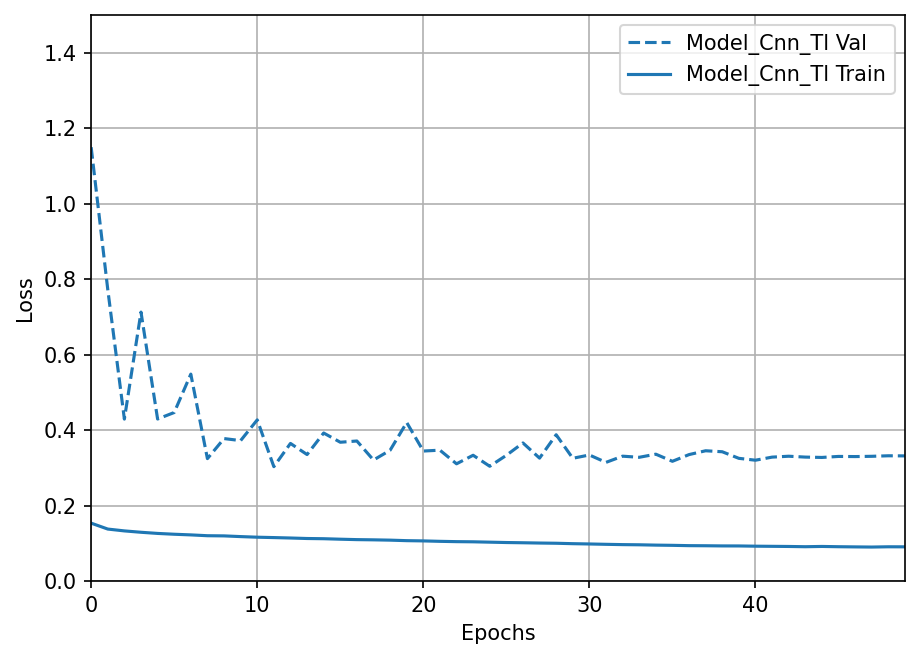

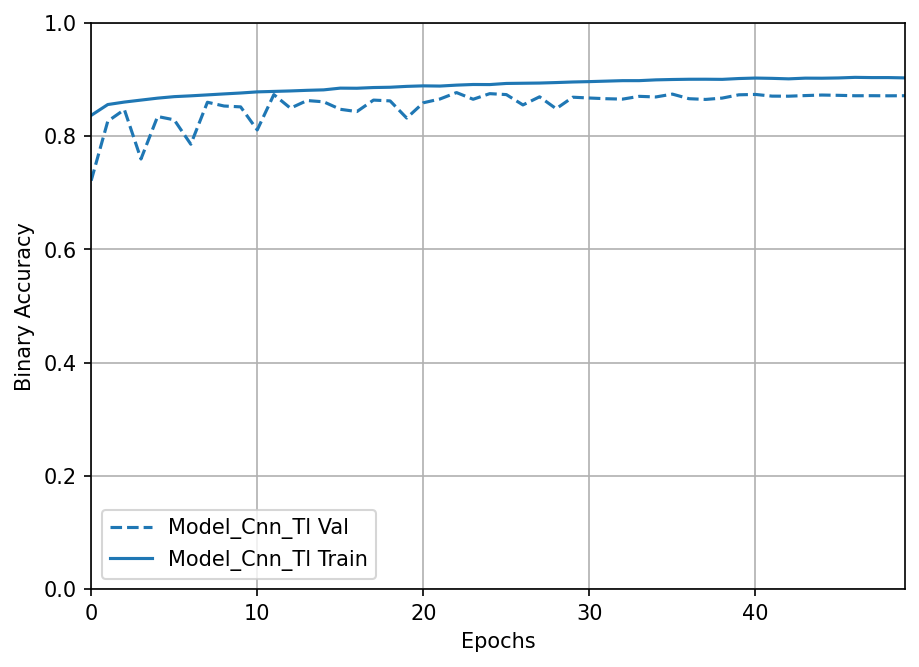

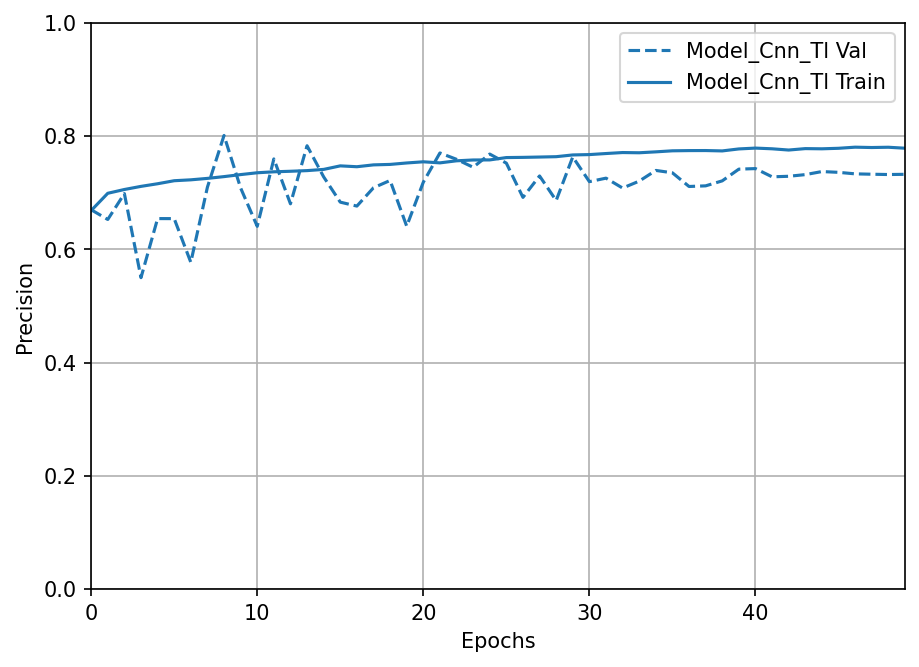

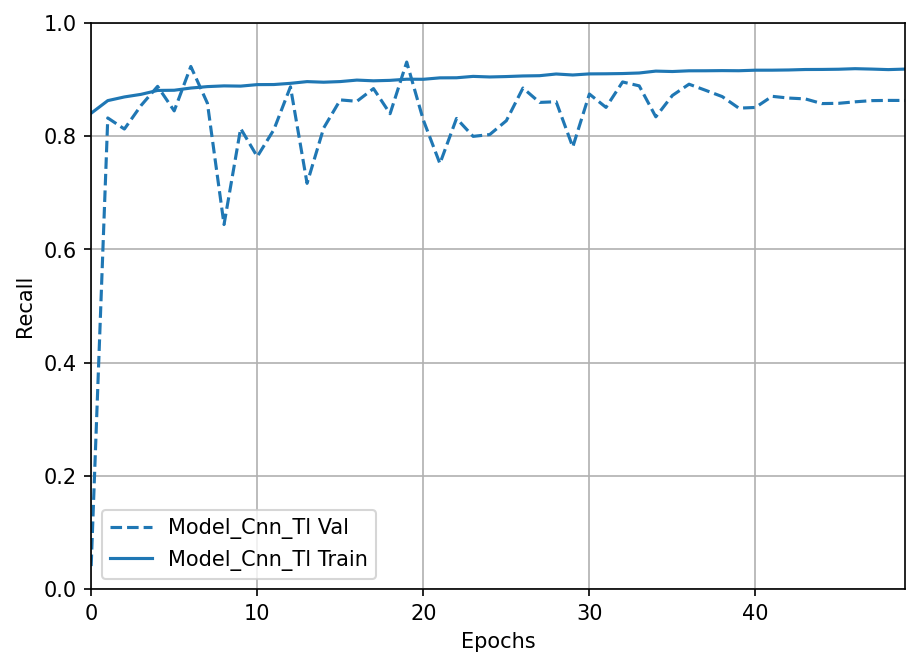

In [43]:
plot_history_models([('Model_CNN_tl', m_history_tl)], key='loss', ylim=[0,1.5])
plot_history_models([('Model_CNN_tl', m_history_tl)], key='binary_accuracy', ylim=[0, 1.0])
plot_history_models([('Model_CNN_tl', m_history_tl)], key='precision', ylim=[0, 1.0])
plot_history_models([('Model_CNN_tl', m_history_tl)], key='recall', ylim=[0, 1.0])

In [44]:
predictions_tl = model_tl.predict(valid_generator)
validation_targets = val_df['Class_label'].astype(int)

val_prd_tl = [1 if v > 0.5 else 0 for v in predictions_tl] # converting to binary
clf_report_tl = classification_report(validation_targets, val_prd_tl, target_names=['class 0', 'class 1'])
print(clf_report_tl)
print("================================================")

651/651 [==============================] - 28s 42ms/step
              precision    recall  f1-score   support

     class 0       0.94      0.87      0.91     59563
     class 1       0.73      0.86      0.79     23695

    accuracy                           0.87     83258
   macro avg       0.84      0.87      0.85     83258
weighted avg       0.88      0.87      0.87     83258



- Precision and recall for class 0 are 0.94 and 0.88, respectively.
- Precision and recall for class 1 are 0.74 and 0.85, respectively.
- F1-score for class 0 is 0.91, and for class 1 is 0.79.
- Overall accuracy of the model is 0.87, meaning it correctly classified 87% of all samples.

### PR Curve

Plotting precision-recall curves for three different models. It computes precision,recall,threshold and average precsion for each model.

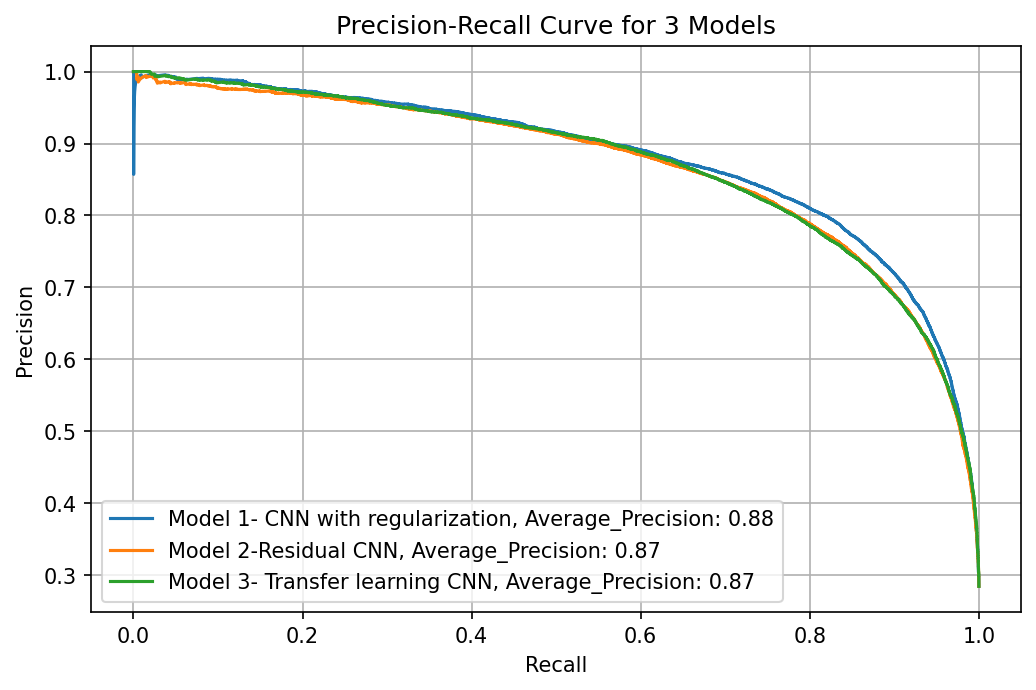

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Generate some sample data
y_true = validation_targets
model1_scores = predictions_reg
model2_scores = predictions_residual
model3_scores = predictions_tl

# Compute precision and recall for each model
precision1, recall1, threshold1 = precision_recall_curve(y_true, model1_scores)
precision2, recall2, threshold2 = precision_recall_curve(y_true, model2_scores)
precision3, recall3, threshold3 = precision_recall_curve(y_true, model3_scores)


AP1 = sklearn.metrics.average_precision_score(y_true, model1_scores)
AP2 = sklearn.metrics.average_precision_score(y_true, model2_scores)
AP3 = sklearn.metrics.average_precision_score(y_true, model3_scores)



# Set the figure size
fig, ax = plt.subplots(figsize=(8, 5),  dpi=150)

# Plot the precision-recall curves for each model
ax.plot(recall1, precision1, label=f'Model 1- CNN with regularization, Average_Precision: {AP1:.2f}')
ax.plot(recall2, precision2, label=f'Model 2-Residual CNN, Average_Precision: {AP2:.2f}')
ax.plot(recall3, precision3, label=f'Model 3- Transfer learning CNN, Average_Precision: {AP3:.2f}')


# Add labels and legend
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve for 3 Models')
ax.legend()
ax.grid('on')


# Show the plot
plt.show()



 Model 1 has a slightly better precision and recall. Therefore, Model 3 is the recommended model for deployment

In [52]:
idx = 59600

print(recall1[idx])

print(precision1[idx])

print(threshold1[idx])

0.8032496307237814
0.8077151587166864
0.649907


Our goal was to achieve a balanced precision and recall while maintaining a minimum recall of 80%, given that this is a breast cancer prediction problem. Through multiple trials, we determined that a threshold of approximately 64.9% is ideal for achieving this balance. We recommend using this threshold when deploying the model